<a href="https://colab.research.google.com/github/linuscov/CCA-/blob/main/28.01.23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
c

## Background
Social Media as envolved into a major platform for political advertisement over the last decades, overtaking many of the the former forms of visual advertising (television, offline) (Fowler 2021). This further intensifies the impact that social media has on our current politial and social landscape. While the desirability of these implications is highly debateable, some argue for a significant deliberation (Castells 2012) while others point more towards the significant dangers that this development entails (Persily & Tucker 2020).

Notwithstanding of these differences it becomes clear that the further understanding of especially politically motivated activety on social is of utmost importance for developing a clearer picture on our political landscape. 

While this field has in the past mainly concentrated on textual data, a rapid development in image and video analysis using quantitative methods of computer vision have opened a huge potential to also include visual data in the anayis. A recent example for this is the work by Fowler et al. (2020), where the authors make use of the Facebook Aid Library as well as television data to capture the strategic use of visual content in political campaigning. They show specific attributes of certain candidates through within-candidate comparison as well as the specifics of social media through an inter-platform comparison.

While a lot of attention in political communication research is paid to the direct often one-dimensional communication between parties (and party representatives) and the people another important aspect are political organizations often taking some kind of an intermediate role between the two. For this reason the present project focuses on the vidual output of the two biggest German environemtal organization: Greenpeace and NABU. 

## Installign packages 

In [11]:
# Install general packages 
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
from collections import Counter
import pandas as pd
import seaborn as sns 

# Install and load packages for web-scraping 
import requests
from bs4 import BeautifulSoup
from io import BytesIO

# Install packages for Computer Vision 
import cv2
from PIL import Image
import torch 




## Loading pictures from the Web 
The URLs seem to change at some point so the following lines might not work anymore, I still included them as well for the sake completeness. 

Below I also included the code to directly load the picture from a github - repository.

In [ ]:
# Loading URLs
urls = pd.read_csv("urls.csv", delimiter = ",")

# Create a list of URLs 
urls_ls = list()
for url in urls:
  urls_ls.append(url)

In [23]:
# Loading images 
images = []
images_array = []
for url in urls_ls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img_array = np.asarray(img)
  images_array.append(img_array)
  images.append(img)

In [3]:
# Save Images 
for img in images:
  file_name =  str('%02d' % images.index(img)) + "_img.jpeg"
  img.save(file_name)

For directly importing the images from Github, start from here.

In [1]:
# Clone Github in Google Colab files to access images 
!git clone https://github.com/linuscov/CV.git

Cloning into 'CV'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 68 (delta 2), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (68/68), 1014.33 KiB | 8.05 MiB/s, done.


In [5]:
# Loading images from storage
x2 =[]
x = range(20)
for i in x:
  two_digit = '%02d' % i
  x2.append(two_digit)

images = []
images_array = []
for i in x2:
  path = "/content/CV/Pictures/" + str(i) + "_img.jpeg"
  img = Image.open(path)
  img_array = np.asarray(img)
  images_array.append(img_array)
  images.append(img)


## Comparison of Pictures 

### Compare Color Composition


In [ ]:
#Check for shapes of pictures   
shapes = []
for img in images_array:
  shape = img.shape
  shapes.append(shape)

In [6]:
# Resizing all image to the the same seize so that all pictures have the same weight for the following 
# analysis of color composiiton 
images_resized = []
images_resized_array = []
for i in images:
    img = i.resize((300,300))
    img_array = np.asarray(img)
    images_resized.append(img)
    images_resized_array.append(img_array)

In [7]:
#Define images from Greenpeace and NABU 
images_nabu = images[0:10]
images_gp= images[10:20]

images_nabu_array = images_array[0:10]
images_gp_array = images_array[10:20]

images_nabu_resized = images_resized[0:10]
images_gp_resized = images_resized[10:20]

images_nabu_resized_array = images_resized_array[0:10]
images_gp_resized_array = images_resized_array[10:20]

In [ ]:
# Merge Pictures from both organisation together in order to conduct the analysis of color 
# composition for all pictures from one organization 

# Merge Greenpeace images together 
widths, heights = zip(*(i.size for i in images_gp_resized))

# Define width and height of the merged picture
total_width = sum(widths)
max_height = max(heights)

green = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images_gp_resized:
  green.paste(im, (x_offset,0))
  x_offset += im.size[0]


# Merge NABU images together 
widths, heights = zip(*(i.size for i in images_nabu_resized))

# Define width and height of the merged picture
total_width = sum(widths)
max_height = max(heights)

nabu = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images_nabu_resized:
  nabu.paste(im, (x_offset,0))
  x_offset += im.size[0]

In [ ]:
# Utility function, rgb to hex
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex
print(rgb2hex([255, 0, 0]))

In [27]:
# Define function to extract color composition 
def plot_image_info(img, k=6):
    # convert image to c2 format
    img_cv = np.array(img) 
    img_rgb = img_cv
    
    #cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    # resize image to speed up processing time
    resized_img_rgb = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_AREA)

    # reshape the image to be a list of pixels
    img_list = resized_img_rgb.reshape((resized_img_rgb.shape[0] * resized_img_rgb.shape[1], 3))

    # cluster the pixels and assign labels
    clt = KMeans(n_clusters=k)
    labels = clt.fit_predict(img_list)
        
    # count labels to find most popular
    label_counts = Counter(labels)
    total_count = sum(label_counts.values())

    # subset out most popular centroid
    center_colors = list(clt.cluster_centers_)
    ordered_colors = [center_colors[i]/255 for i in label_counts.keys()]
    color_labels = [rgb2hex(ordered_colors[i]*255) for i in label_counts.keys()]
    
    #print(label_counts.values())
    #print(color_labels)
    
    # plots
    plt.figure(figsize=(14, 8))
    plt.subplot(221)
    plt.imshow(img_rgb)
    plt.axis('off')
    
    plt.subplot(222)
    plt.pie(label_counts.values(), labels=color_labels, colors=ordered_colors, startangle=90)
    plt.axis('equal')
    plt.show()

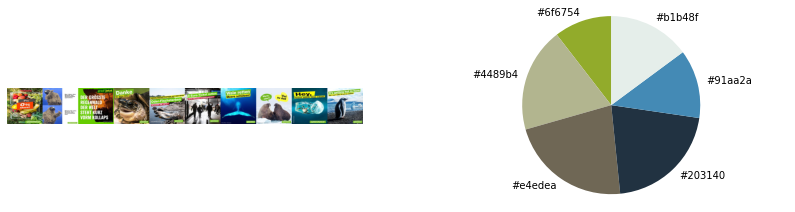

In [30]:
plot_image_info(green)

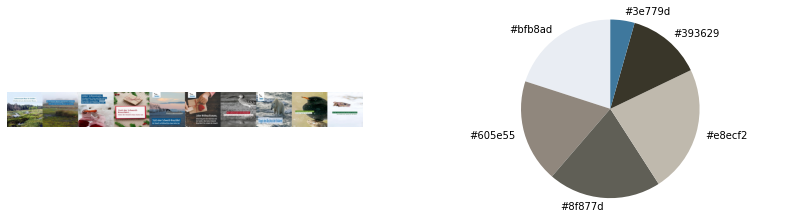

In [31]:
plot_image_info(nabu)

Due to the very limited sample of pictures such a color composition analysis should be treated with caution and mainly used as a descriptitve measure. Here we can see what already becomes apparent from the consideration of the pictures themselves, that Greenpeace seems to an average use more green and lighter color while Nabu relied more on darker tones of brown, grey, and blue. 

### Similarity measure 

In the following the intra- and inter-similarity of the images posted by the two organizations should be elaborated in more detail  

In [11]:
# Create an empty matrix to illustrate similarity measures 
matrix = np.empty((10, 10))



In [22]:
# Calculating Structural Similarities between all pictures 
ssims_gp = []
for img_gp in images_gp_resized_array:
  current_img_gp_ssims = []
  for img in images_gp_resized_array:
    struc_sim = ssim(img_gp, img, multichannel=True)
    current_img_gp_ssims.append(struc_sim)
  ssims_gp.append(current_img_gp_ssims)

ssims_nabu = []
for img_nabu in images_nabu_resized_array:
  current_img_nabu_ssims = []
  for img in images_nabu_resized_array:
    struc_sim = ssim(img_nabu, img, multichannel=True)
    current_img_nabu_ssims.append(struc_sim)
  ssims_nabu.append(current_img_nabu_ssims)

ssims_between = []
for img_gp in images_gp_resized_array:
  current_img_gp_ssims = []
  for img in images_nabu_resized_array:
    struc_sim = ssim(img_gp, img, multichannel=True)
    current_img_gp_ssims.append(struc_sim)
  ssims_between.append(current_img_gp_ssims)


# for img_nabu in images_nabu_resized_array:
#   current_img_sims = []
#   for img in images_resized_array:
#     struc_sim = ssim(img_nabu, img, multichannel=True)
#     current_img_sims.append(struc_sim)
#   struc_sims.append(current_img_sims)


In [ ]:
ssims_gp

In [21]:
# Plotting structural differences 
ssims_gp_df = pd.DataFrame(ssims_gp)

ssims_gp_df[ssims_gp_df > 0.9] = np.nan

cm = sns.light_palette("green", as_cmap=True)

ssims_gp_df.style.background_gradient(cmap=cm, axis = None, low = 0, high = 0.5)

,0,1,2,3,4,5,6,7,8,9
0,nan,0.058025,0.026826,0.050995,0.033173,0.034492,0.056757,0.056637,0.053538,0.046334
1,0.058025,nan,0.073858,0.123081,0.168534,0.081032,0.156226,0.294544,0.172393,0.126077
2,0.026826,0.073858,nan,0.063044,0.069637,0.028467,0.067948,0.095608,0.063951,0.039070
3,0.050995,0.123081,0.063044,nan,0.102602,0.060583,0.122108,0.152582,0.120229,0.085936
4,0.033173,0.168534,0.069637,0.102602,nan,0.065781,0.095551,0.239552,0.109929,0.102397
5,0.034492,0.081032,0.028467,0.060583,0.065781,nan,0.075950,0.081565,0.061030,0.048418
6,0.056757,0.156226,0.067948,0.122108,0.095551,0.075950,nan,0.182567,0.280663,0.148843
7,0.056637,0.294544,0.095608,0.152582,0.239552,0.081565,0.182567,nan,0.170325,0.156955
8,0.053538,0.172393,0.063951,0.120229,0.109929,0.061030,0.280663,0.170325,nan,0.086978
9,0.046334,0.126077,0.039070,0.085936,0.102397,0.048418,0.148843,0.156955,0.086978,nan


In [23]:
# Plotting structural differences for NABU
ssims_nabu_df = pd.DataFrame(ssims_nabu)

ssims_nabu_df[ssims_nabu_df > 0.9] = np.nan

cm = sns.light_palette("green", as_cmap=True)

ssims_nabu_df.style.background_gradient(cmap=cm, axis = None, low = 0, high = 0.5)

,0,1,2,3,4,5,6,7,8,9
0,nan,0.261980,0.198359,0.122889,0.253144,0.129079,0.144367,0.094523,0.201333,0.263344
1,0.261980,nan,0.247696,0.151104,0.311010,0.197355,0.182776,0.118788,0.242779,0.303969
2,0.198359,0.247696,nan,0.183428,0.282977,0.153404,0.185979,0.105300,0.203993,0.378195
3,0.122889,0.151104,0.183428,nan,0.193859,0.132726,0.161279,0.097199,0.174271,0.299503
4,0.253144,0.311010,0.282977,0.193859,nan,0.256945,0.197405,0.129609,0.260766,0.371908
5,0.129079,0.197355,0.153404,0.132726,0.256945,nan,0.176974,0.100570,0.201244,0.201804
6,0.144367,0.182776,0.185979,0.161279,0.197405,0.176974,nan,0.097341,0.217011,0.267232
7,0.094523,0.118788,0.105300,0.097199,0.129609,0.100570,0.097341,nan,0.107129,0.150923
8,0.201333,0.242779,0.203993,0.174271,0.260766,0.201244,0.217011,0.107129,nan,0.386009
9,0.263344,0.303969,0.378195,0.299503,0.371908,0.201804,0.267232,0.150923,0.386009,nan


In [24]:
# Plotting structural differences between Greenpeace and NABU 
ssims_between_df = pd.DataFrame(ssims_between)

ssims_between_df[ssims_between_df > 0.9] = np.nan

cm = sns.light_palette("green", as_cmap=True)

ssims_between_df.style.background_gradient(cmap=cm, axis = None, low = 0, high = 0.5)

,0,1,2,3,4,5,6,7,8,9
0,0.049051,0.061496,0.053692,0.058065,0.062427,0.066448,0.055441,0.049237,0.056069,0.065475
1,0.206350,0.231832,0.309394,0.191707,0.276157,0.159256,0.190110,0.101330,0.191671,0.418931
2,0.060881,0.082870,0.079584,0.062760,0.087315,0.095854,0.088949,0.043611,0.129800,0.125463
3,0.104860,0.131519,0.128672,0.094933,0.133972,0.134492,0.152242,0.063670,0.175663,0.174164
4,0.211241,0.231249,0.171092,0.115686,0.202131,0.112087,0.139447,0.083795,0.204074,0.259663
5,0.065359,0.079084,0.075577,0.063246,0.087303,0.076033,0.063251,0.044632,0.079374,0.117888
6,0.126816,0.165474,0.168654,0.113082,0.209205,0.172327,0.130346,0.077489,0.199460,0.200996
7,0.263778,0.303034,0.291891,0.178861,0.324602,0.180430,0.194147,0.122184,0.285493,0.409196
8,0.109297,0.137919,0.147561,0.118731,0.182120,0.155927,0.181511,0.071139,0.177718,0.212164
9,0.147757,0.142787,0.139471,0.087821,0.176818,0.100821,0.084500,0.070671,0.113811,0.172295


In [35]:
# Caculating the average SSIM value for the pictures of Nabu and Greenpeace 
ssims_gp_mean = round(np.nanmean(ssims_gp), 2)
print("Mean Structurall Differenc of Greenpeace pictures: " + str(ssims_gp_mean))

ssims_nabu_mean = round(np.nanmean(ssims_nabu), 2)
print("Mean Structurall Differenc of Nabu Pictures: " + str(ssims_nabu_mean))

ssims_between_mean = round(np.nanmean(ssims_between),2)
print("Mean Structurall Differenc between the picture from NABU and Greenpeace: " + str(ssims_between_mean))

Mean Structurall Differenc of Greenpeace pictures: 0.19
Mean Structurall Differenc of Nabu Pictures: 0.28
Mean Structurall Differenc between the picture from NABU and Greenpeace: 0.14


The means for the Structural Differences illustrate again what already emerged from the colored charts. Both show a higher similarity between pictures from the same organization compared to the similarity across organizations. This is insofar not very surprising as the media presence of organizations is often based on some form of base design which is evident throughout. What is maybe more interesting here and could potentionally be the starting point of further investigation, is the much higher similarity of pictures from NABU compared with those from Greenpeace. Regarding this one could ask if this also relates back to the discussed topics which might potentionally be more heterogenous for Greenpeace. 

In [46]:
# Calculating Mean-Sqaured differences for all pictures 

from skimage.metrics import mean_squared_error

mses = []
for img_nabu in images_nabu_resized_array:
  current_img_mses = []
  for img in images_resized_array:
    mse = mean_squared_error(img_nabu, img)
    current_img_mses.append(mse)
  mses.append(current_img_mses)

In [48]:
# Plotting Mean Squared Erros 
mse_df = pd.DataFrame(mses)

mse_df[mse_df < 1] = np.nan

cm = sns.light_palette("green", as_cmap=True)

mse_df.style.background_gradient(cmap=cm, axis = None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,nan,3860.228819,8974.992667,11303.998000,4598.445841,12208.517578,10136.374841,9350.961256,12760.134674,15595.021870,12485.636289,11304.137937,19078.238256,14989.126926,8257.494593,14615.256530,12560.647315,9613.885289,15368.849974,6308.858644
1,3860.228819,nan,9271.349811,12316.365522,3870.491644,8378.954996,8943.617207,8531.246400,9473.355900,18854.651452,10447.948219,13956.835074,15976.820059,11655.921426,7378.977626,13438.439822,8924.811593,10014.774426,13191.443304,6253.341048
2,8974.992667,9271.349811,nan,9522.591844,7750.018781,14251.844748,8668.527033,9515.760322,14402.806007,11561.861352,13242.760230,7813.570863,19944.588189,14907.054126,9495.168459,16273.897174,16857.161011,10523.876674,15816.356967,9659.405481
3,11303.998000,12316.365522,9522.591844,nan,9192.714804,13089.639281,7765.423567,8803.284752,13010.155637,11470.891974,11010.099163,10961.598678,16615.879574,12266.904007,9804.793896,14450.062085,18136.494367,11886.931741,13090.882789,12402.616526
4,4598.445841,3870.491644,7750.018781,9192.714804,nan,8459.545559,7272.955200,6294.789081,10504.919004,13368.036281,10178.481011,10315.123022,15401.838556,12176.156389,6932.537707,11215.784763,10082.205230,8075.437856,11362.517926,5778.651233
5,12208.517578,8378.954996,14251.844748,13089.639281,8459.545559,nan,6784.729278,9952.177137,8637.936563,25541.610900,8227.936704,19029.839485,11833.096041,8081.983533,11707.975037,11763.994381,9968.868241,16808.380778,10513.181907,12226.666941
6,10136.374841,8943.617207,8668.527033,7765.423567,7272.955200,6784.729278,nan,7084.190526,9439.247552,17204.611770,7386.534811,11266.753133,10926.780170,7296.429574,9942.183559,9823.431244,10947.030141,12109.242107,7106.244341,10204.790411
7,9350.961256,8531.246400,9515.760322,8803.284752,6294.789081,9952.177137,7084.190526,nan,7050.395996,10266.292452,10205.032411,11461.990281,14676.888126,9365.862915,8606.639367,10518.791170,13694.955667,8930.856056,13143.914748,11108.340456
8,12760.134674,9473.355900,14402.806007,13010.155637,10504.919004,8637.936563,9439.247552,7050.395996,nan,19050.295522,9925.007956,19597.533219,12874.046033,7156.862259,10914.262000,12394.199811,13556.670789,13626.651785,15154.138581,14745.280000
9,15595.021870,18854.651452,11561.861352,11470.891974,13368.036281,25541.610900,17204.611770,10266.292452,19050.295522,nan,22270.879744,9918.523193,28576.232289,22465.766833,13636.535885,21101.797193,29792.497044,10500.866507,26678.113548,17968.776389


### Object Detection 

In this chapter the specific content of the pictures should be investigated in more detail. 

For this I am using YOLOv5 which is "is a family of compound-scaled object detection models trained on the COCO dataset" (https://pytorch.org/hub/ultralytics_yolov5/) that runs on the backend of Pytorch. Yolo (You only look once) models are single stage networks which use a "single neural network to output detections at a variety of locations" (Szeliski 2022)




In [49]:

model = pipeline("object-detection")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.5 MB/s eta 0:00:00


No model was supplied, defaulted to facebook/detr-resnet-50 and revision 2729413 (https://huggingface.co/facebook/detr-resnet-50).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Downloading:   0%|          | 0.00/274 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [51]:
model("0_img.jpeg")

[]

In [ ]:
# installing OpenCV  
!pip install opencv-python  
  
# installing TensorFlow  
!pip install tensorflow  
  
# installing Keras  
!pip install keras  
  
# installing ImageAI  
!pip install imageAI  

In [ ]:
# importing the required library  
from imageai.Detection import ObjectDetection  

In [55]:
# instantiating the class  
recognizer = ObjectDetection()  

In [56]:
# using the setModelTypeAsTinyYOLOv3() function  
recognizer.setModelTypeAsTinyYOLOv3()  

In [57]:
# setting the path to the pre-trained Model  
recognizer.setModelPath("yolo-tiny.h5") 

RuntimeError: ignored

In [5]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()

In [16]:
detector.setModelTypeAsRetinaNet()

In [13]:
detector.setModelTypeAsTinyYOLOv3()

In [14]:
detector.setModelPath("tiny-yolov3.pt")

In [17]:
detector.setModelPath("retinanet_resnet50_fpn_coco-eeacb38b.pth")

RuntimeError: ignored

In [18]:
detector.loadModel()

In [22]:
img = images[0]
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [25]:
detections = detector.detectObjectsFromImage(input_image= images[4], output_image_path="imagenew.jpg", minimum_percentage_probability=30)


In [27]:
for eachItem in detections:  
    print(eachItem["name"] , " : ", eachItem["percentage_probability"])  

### Next Try

In [8]:
# Clone Github repository to access the included fies 
!git clone https://github.com/ultralytics/yolov5  # clone

# Change working directory to yolov5
os.chdir("/content/yolov5")

# install rquired packages 
!pip install -r requirements.txt  

Cloning into 'yolov5'...
remote: Enumerating objects: 15002, done.
remote: Total 15002 (delta 0), reused 0 (delta 0), pack-reused 15002
Receiving objects: 100% (15002/15002), 14.08 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (10285/10285), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00


In [9]:
os.chdir("/content/yolov5/data/images")

In [34]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.0/107.7 GB disk)


In [11]:
# Save images in yolov5 folder 
for img in images:
  file_name =  str('%02d' % images.index(img)) + "_img.jpeg"
  img.save(file_name)

In [17]:
os.chdir("/content/yolov5")

In [14]:
detection = !python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images

^C


In [72]:
detection[5]

'image 1/22 /content/yolov5/data/images/00_img.jpeg: 640x384 (no detections), 288.4ms'

In [12]:
# Define the model 
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Detect objecs in the images 
images_detect = []
for img in images:
  img_detect = model(img)
  images_detect.append(img_detect)

# save images 
for img in images_detect:
  img.save


/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-1-28 Python-3.8.10 torch-1.13.1+cu116 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [27]:
images_detect[2].show

<bound method Detections.show of YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 600x338 1 carrot
Speed: 3.1ms pre-process, 236.9ms inference, 1.0ms NMS per image at shape (1, 3, 640, 384)>

In [18]:
# Define the model 
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True))

images_detect = model(images)

images_detect.print()  
images_detect.save()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-28 Python-3.8.10 torch-1.13.1+cu116 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/20: 600x338 (no detections)
image 2/20: 600x338 (no detections)
image 3/20: 600x338 1 carrot
image 4/20: 600x338 1 book
image 5/20: 600x600 1 boat
image 6/20: 600x600 2 persons
image 7/20: 600x338 1 bird
image 8/20: 314x600 1 bear
image 9/20: 600x338 2 birds
image 10/20: 600x338 1 bird
image 11/20: 600x338 2 bananas, 8 apples, 1 orange
image 12/20: 600x341 1 bird, 1 dog, 2 bears
image 13/20: 600x600 (no detections)
image 14/20: 600x600 (no detections)
image 15/20: 600x600 (no detections)
image 16/20: 600x600 10 persons, 1 train, 1 backpack
image 17/20: 600x600 (no detections)
image 18/20: 600x600 1 elephant
image 19/20: 600x338 1 bird, 1 vase
image 20/20: 600x600 1 dog
Speed: 7.5ms pre-process, 426.5ms inference, 0.9ms NMS per image at shape (20, 3, 640, 640)
Saved 20 images to runs/detect/exp


In [ ]:
images_detect.show()

Looking at the detected objects in the picture it becomes apparent that the model is doing a reatively poor job in detecting the objects. 
While beeing relatively accurate in detecting a group of humans with backpacks at a train station, many of the depicted animals were classified wrongly. Natural sourrounding like wetlands, ozean, etc. were not classified at all. This shows the need for a model which is more alligned with the topic at hand. For this project (on environmental organizations) for example it would need a model that is specifically trained for animals and natural landscapes. Instead of taking a pretrained model model one could also self-train the model with according pictures. However, this would go beyond the scope of this work. 


In [25]:
# Printing detected objects in a dataframe
images_detect[4].pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,261.998413,335.452789,577.724182,395.50415,0.423763,8,boat


In [22]:
plt.imshow(images_detect[2])

TypeError: ignored

In [16]:
results

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 600x338 1 carrot
Speed: 47.7ms pre-process, 302.6ms inference, 22.4ms NMS per image at shape (1, 3, 640, 384)

In [57]:
os.chdir("/content/yolov5/runs/detect/exp")

In [58]:
# Loading images with detected objects from storage
x2 =[]
x = range(20)

for i in x:
  two_digit = '%02d' % i
  x2.append(two_digit)

images_detec_array = []
images_detec = []
for i in x2:
  img_name = str(i) + "_img.jpeg"
  img = Image.open(img_name)
  img_array = np.asarray(img)
  images_detec_array.append(img_array)
  images_detec.append(img)

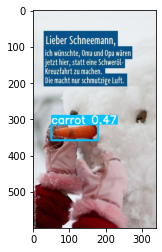

In [62]:
plt.imshow(images_detec[2])

## Reference List 
Szeliski, R. (2022). Computer vision: algorithms and applications. Springer Nature. 

Fowler, E. F., Franz, M. M., Martin, G. J., Peskowitz, Z., & Ridout, T. N. (2021). Political advertising online and offline. American Political Science Review, 115(1), 130-149.